In [1]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data_loader import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

## Data Loading

Config initialisation

In [2]:
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

In [3]:
data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,feature_44,feature_45,feature_46,…,feature_52,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,feature_time_sin,feature_time_cos
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64
0,35,1,3.889038,0.127298,0.339121,-0.045494,0.151473,-0.038995,-0.644192,-0.193971,-0.016662,-0.213108,-0.045016,0.014899,0.128033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.397016,0.694868,0.812098,-0.128621,0.025559,0.018694,-0.006306,-1.706433,-0.490941,0.425017,0.281025,-0.134582,0.046605,…,-0.207253,-0.307967,0.381731,0.756464,0.058235,0.060041,-0.479444,-0.000608,0.0,-0.000122,0.085259,-0.324355,-0.097414,-0.296044,0.21344,-0.20025,-0.11987,-0.007101,-0.693186,-0.181427,0.073886,-0.062266,0.136151,0.110356,0.055748,-0.028266,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,0.225461,0.974252
0,36,1,3.889038,0.114208,-1.419921,-0.505525,-0.258195,0.017889,-0.254385,0.015691,-0.020583,-0.15111,-0.034961,-0.045215,-0.411787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037745,-0.824408,-0.312367,0.272155,0.041673,0.051002,0.101001,-0.172871,0.356697,0.43781,-0.243426,0.116691,0.21925,…,0.174336,-0.325709,-0.301785,-0.332396,0.651199,-0.103911,-0.210683,0.088785,0.0,-0.013245,-0.067586,0.22172,0.347892,0.511532,-0.214167,-0.045423,-0.048534,0.048807,-0.407794,0.008081,-0.071584,0.056597,0.01653,-0.049644,-0.023103,-0.0531,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,0.231787,0.972767
0,37,1,3.889038,0.118826,-1.293755,-0.809856,0.268584,-0.056675,-0.273341,-0.016404,0.010669,0.172457,0.011381,0.013246,-0.016248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571682,0.168574,-0.042331,-0.55658,0.175519,-0.052067,0.053939,0.109843,-0.055707,-0.214608,-0.026042,-0.180718,-0.171372,…,-1.097941,-0.294437,-0.104787,0.504722,-0.285762,0.140226,-0.521822,-0.46183,0.0,0.226184,-0.100162,-0.029472,0.037072,0.097566,0.061552,-0.136708,-0.029742,-0.047774,-0.150518,-0.287006,-0.000054,-0.048201,-0.093462,-0.015866,0.051347,0.055587,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,0.238102,0.97124
0,38,1,3.889038,-0.216346,-0.021069,-0.425764,-0.005701,-0.010654,0.302838,0.000491,-0.017648,-0.036415,-0.008958,0.384812,0.49453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.202302,0.395804,-0.512155,0.642004,0.414221,0.113961,-0.131998,-0.374575,0.206433,-0.445924,-0.518108,0.268771,0.069906,…,0.08609,-0.610097,0.137679,-0.198983,-0.754921,-0.294851,0.352242,0.049567,0.0,-0.023089,0.036929,-0.176699,-0.503255,-0.449954,-0.134894,0.050516,-0.089379,0.004014,-0.204778,-0.144482,-0.082102,-0.050271,0.020269,-0.008658,0.096835,-0.042524,0.423799,-0.195033,0.145029,-0.076218,-0.304814,0.098249,-0.606483,-0.01076,-0.134628,0.244408,0.969673
0,39,1,3.889038,-0.660073,2.168059,0.903407,-0.101644,0.133174,-0.212203,-0.217244,0.006182,-0.076704,-0.027879,0.249095,-0.431726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.511043,-0.221639,-0.014473,-0.572408,-0.297749,-0.126506,-0.083542,0.180433,-0.245343,0.052368,0.051568,-0.067317,0.585641,…,0.422847,1.033209,-0.497286,-0.080836,0.111428,0.3511

Define features and target

In [4]:
target = "responder_6"
features = [col for col in data.columns if "feature" in col]

X, y = data[features], data[target]
X = X[:100000]
y = y[:100000]

n = X.shape[0]

X_train = X[:int(0.8*n)]
y_train = y[:int(0.8*n)]

X_val = X[int(0.8*n):]
y_val = y[int(0.8*n):]

In [5]:
import transformer
from utils import train_model, TimeSeriesDataset

Epoch 001 | R² train = -0.0761 | R² val = -0.0101
Epoch 002 | R² train = -0.0059 | R² val = -0.0031
Epoch 003 | R² train = -0.0050 | R² val = -0.0062
Epoch 004 | R² train = -0.0015 | R² val = -0.0100
Epoch 005 | R² train = 0.0006 | R² val = -0.0071
Epoch 006 | R² train = 0.0079 | R² val = -0.0052
Epoch 007 | R² train = 0.0151 | R² val = -0.0277
Epoch 008 | R² train = 0.0306 | R² val = -0.0531
Epoch 009 | R² train = 0.0649 | R² val = -0.0900
Epoch 010 | R² train = 0.0978 | R² val = -0.1050


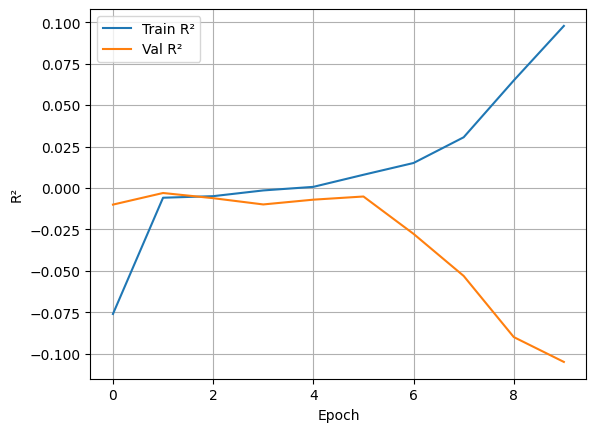

In [18]:
n_features = X_train.shape[1]
lr = 1e-3
criterion = nn.MSELoss()
n_epochs = 10
batch_size = 2**11
device = "cuda"
seq_len = 16
d_model=64
num_heads=4
num_layers=2
d_ff=128

model = transformer.TimeSeriesTransformer(
    n_features=n_features,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff
)

optimizer = optim.Adam(model.parameters(), lr=lr)

r2_train_hist, r2_val_hist = train_model(
    model, optimizer, criterion, 
    X_train, y_train, X_val, y_val,
    epochs=n_epochs, batch_size=batch_size, device=device
)